In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import sys
sys.path.append('..')

from tools.propagate import create_photon_propagator
from tools.geometry import generate_detector
from tools.utils import load_single_event, save_single_event, print_params, generate_random_params
from tools.losses import compute_loss_with_time
from tools.simulation import setup_event_simulator

import jax.numpy as jnp
from functools import partial
import pickle
from tqdm import tqdm
import jax
from jax import grad, jit, vmap, value_and_grad
from tools.losses import compute_simplified_loss

In [3]:
default_json_filename = '../config/cyl_geom_config.json'

detector = generate_detector(default_json_filename)
detector_points = jnp.array(detector.all_points)
detector_radius = detector.S_radius
NUM_DETECTORS = len(detector_points)
Nphot = 3_00_000
temperatures = [0., 0.5, 1.0]

K=2
event_simulators = {temperature: setup_event_simulator(default_json_filename, Nphot, temperature, K=K) for temperature in temperatures}

In [4]:
# Generate and save a single event
key_id = 149790000
key = jax.random.PRNGKey(key_id)

# Sample true parameter configurations:
random_energy, random_position, random_direction = generate_random_params(key)
true_params = (
    random_energy,          # energy
    random_position,        # track_origin
    random_direction,       # track_direction
    jnp.array(1.0),         # initial_intensity
    jnp.array(10.),         # scatter_length
    jnp.array(0.1),         # reflection_rate
    jnp.array(10.),         # absorption_length
    jnp.array(0.1)         # sim_temperature
)

In [5]:
simulate_true_data = setup_event_simulator(default_json_filename, Nphot, temperature = None, K=K, is_data=True)
simulate_event = event_simulators[temperatures[0]]
true_data = jax.lax.stop_gradient(simulate_true_data(true_params, key))
print_params(true_params[0:3])

Event Parameters:
────────────────────
Energy: 662.00 MeV
Initial Position: (-0.82, -0.14, -0.42)
Initial Direction: (-0.80, 0.34, -0.49)
────────────────────


In [6]:
single_event_data = simulate_event(true_params, key)
save_single_event(single_event_data, true_params, filename='../events/test_event_data.h5')

'../events/test_event_data.h5'

In [7]:
event_location = '../events/test_event_data.h5'
loaded_params, loaded_indices, loaded_charges, loaded_times= load_single_event(event_location, NUM_DETECTORS)

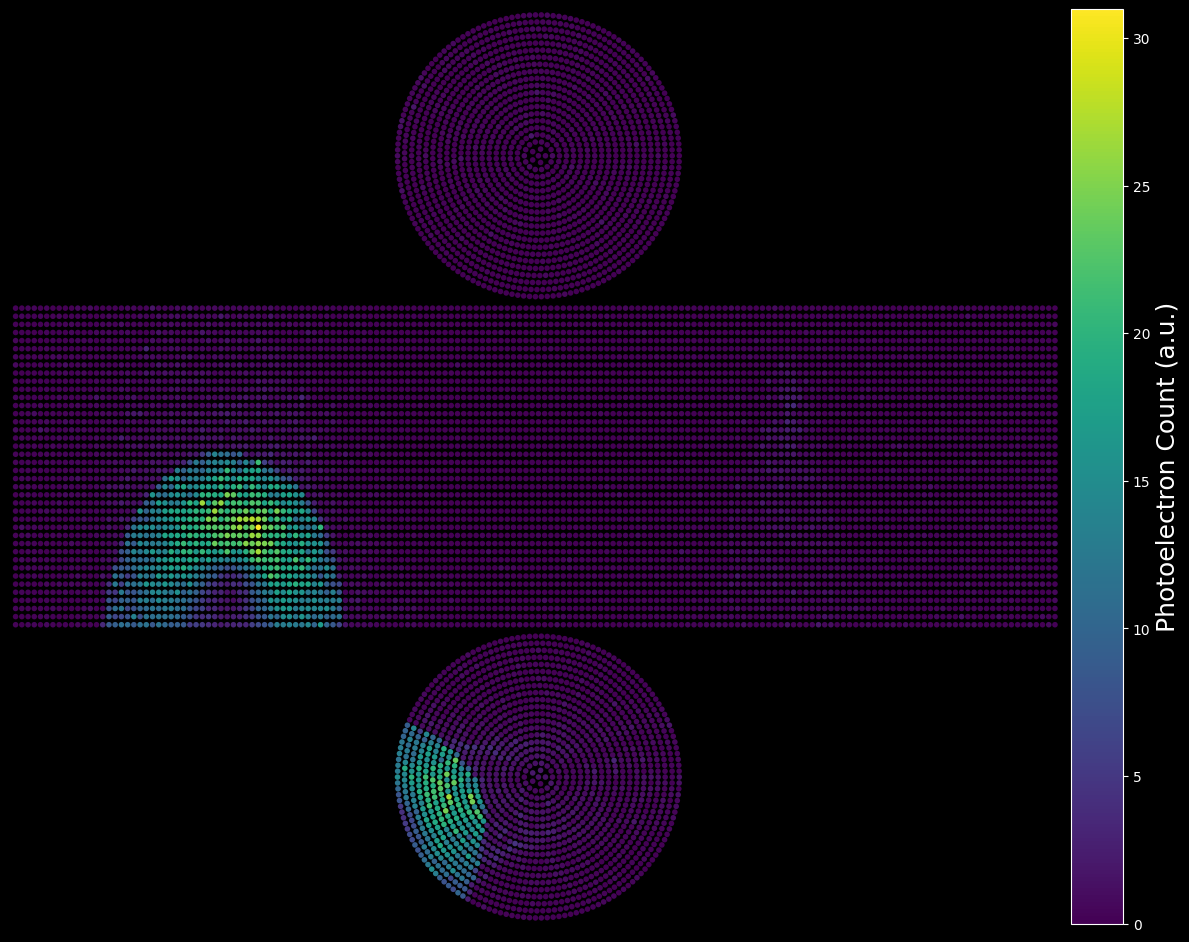

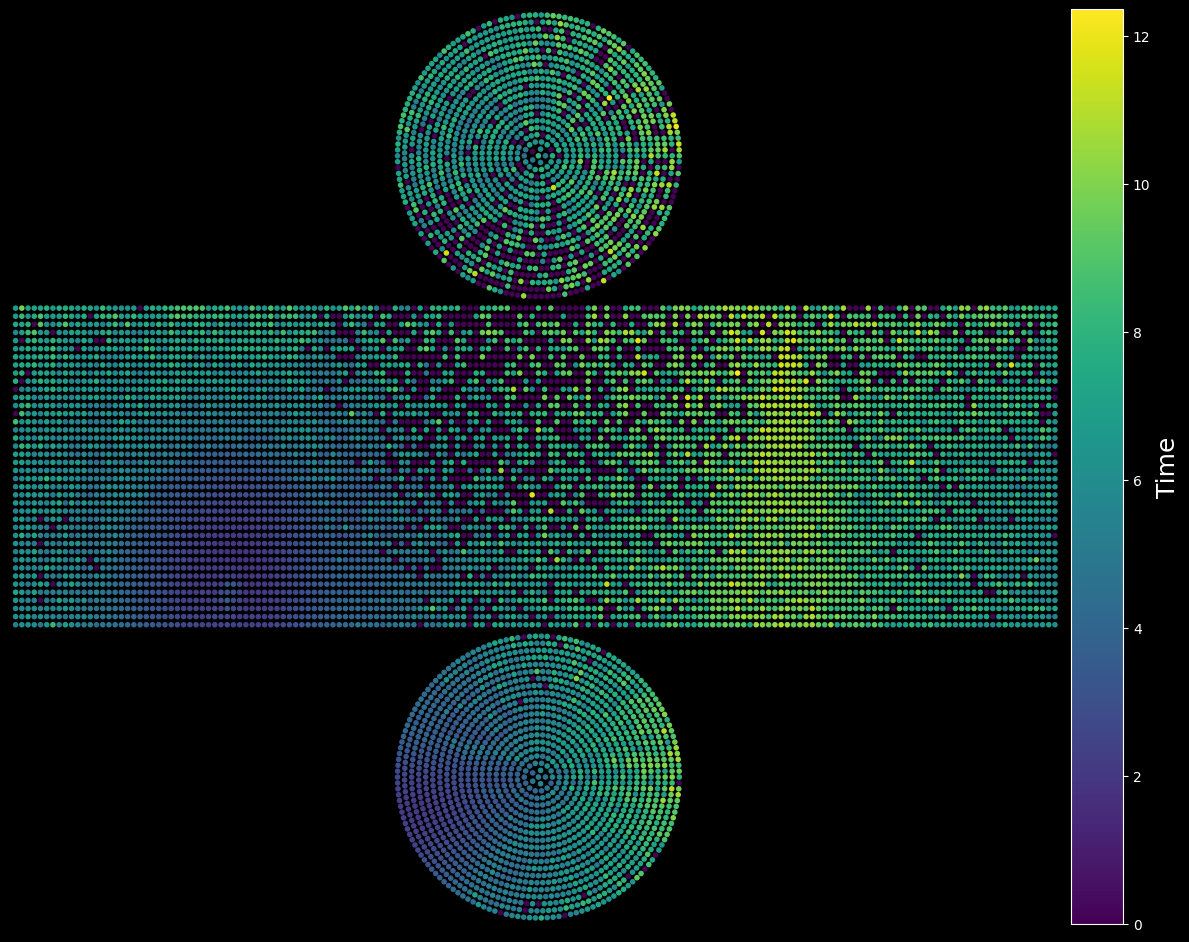

In [8]:
from tools.visualization import create_detector_display
detector_display = create_detector_display()
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='event_display.png', plot_time=False)
detector_display(loaded_indices, loaded_charges, loaded_times, file_name='event_display.png', plot_time=True)

In [9]:
import numpy as np
print('Total Observed Q: ', np.sum(single_event_data[0]))

Total Observed Q:  16221.074


In [10]:
def create_loss_and_grad_fn(simulator, lambda_intensity=0.5, lambda_time=1.0):
    @jit
    def loss_and_grad_fn(params):
        def loss_fn(p):
            simulated_data = simulator(p, key)
            return compute_simplified_loss(detector_points, *true_data, *simulated_data, lambda_intensity=lambda_intensity, lambda_time=lambda_time)
        return value_and_grad(loss_fn)(params)
    return loss_and_grad_fn

def generate_param_ranges(true_params, param_changes, num_points=121):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params, param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # opening angle and intensity
            start = true_param - change
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

def generate_plot_data(param_index, param_values, simulator):
    losses = []
    gradients = []

    loss_and_grad_fn = create_loss_and_grad_fn(simulator, lambda_time=0.000001)

    for new_value in param_values:
        new_params = list(true_params)
        if param_index in [1, 2]:  # position and direction
            new_params[param_index] = new_params[param_index].at[0].set(new_value)
        else:  # opening angle and intensity
            new_params[param_index] = new_value

        new_params = tuple(new_params)
        loss, grad = loss_and_grad_fn(new_params)
        gradient = grad[param_index]
        if param_index in [1, 2]:
            gradient = gradient[0]

        losses.append(loss)
        gradients.append(gradient)

    return jnp.array(losses), jnp.array(gradients)

def generate_analysis_data(true_params, param_changes, temperatures, simulators, num_points=121):
    """Generate and save all analysis data."""
    # Generate parameter ranges
    param_ranges = generate_param_ranges(true_params, param_changes, num_points)
    param_names = ['Energy', 'Position X', 'Direction X']

    # Store all data in a dictionary
    analysis_data = {
        'param_ranges': param_ranges,
        'param_names': param_names,
        'true_params': true_params,
        'temperatures': temperatures,
        'results': {}
    }

    # Generate data for each parameter and temperature
    for param_idx, param_name in enumerate(tqdm(param_names, desc="Parameters")):
        param_values = param_ranges[param_idx]
        analysis_data['results'][param_name] = {}

        for temp in tqdm(temperatures, desc=f"Temperatures for {param_name}", leave=False):
            losses, gradients = generate_plot_data(param_idx, param_values, simulators[temp])
            analysis_data['results'][param_name][temp] = {
                'losses': losses,
                'gradients': gradients
            }

    return analysis_data

def save_analysis_data(analysis_data, filename='analysis_data.pkl'):
    """Save the analysis data to a file."""
    with open(filename, 'wb') as f:
        pickle.dump(analysis_data, f)

def load_analysis_data(filename='analysis_data.pkl'):
    """Load the analysis data from a file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [11]:
from matplotlib import rcParams, rc
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

def plot_analysis_results(analysis_data):
    """
    Plot the analysis results with a common legend for all subplots.

    Args:
        analysis_data: Dictionary containing all the analysis data
    """
    param_names = analysis_data['param_names']
    temperatures = analysis_data['temperatures']
    true_params = analysis_data['true_params']

    colors = [ 'navy', 'cornflowerblue', 'cyan']

    fig, axs = plt.subplots(2, 3, figsize=(10, 6))

    # Lists to store legend handles and labels
    all_lines = []
    all_labels = []

    # First row for losses, second row for gradients
    for param_idx, param_name in enumerate(param_names):
        param_values = analysis_data['param_ranges'][param_idx]
        true_value = true_params[param_idx] if param_idx not in [1, 2] else true_params[param_idx][0]

        ax_loss = axs[0, param_idx]
        ax_grad = axs[1, param_idx]

        for temp_idx, temp in enumerate(temperatures):
            results = analysis_data['results'][param_name][temp]
            losses = results['losses']
            gradients = results['gradients']

            label = f'σ={temp}'
            color = colors[temp_idx]

            # Plot loss and gradient
            line_loss = ax_loss.plot(param_values, losses, color=color, lw=1.5)[0]
            line_grad = ax_grad.plot(param_values, gradients, color=color, lw=1.5)[0]

            # Only store temperature-related legend items from the first parameter
            if param_idx == 0:
                all_lines.append(line_loss)
                all_labels.append(label)

        # Add reference lines
        true_line = ax_loss.axvline(x=true_value, color='black', linestyle='--')
        ax_grad.axvline(x=true_value, color='black', linestyle='--')

        zero_line = ax_grad.axhline(y=0, color='gray', linestyle=':')

        # Only store reference lines from the first parameter
        if param_idx == 0:
            all_lines.extend([true_line, zero_line])
            all_labels.extend(['True Value', 'Zero Gradient'])

        # Configure axes without individual legends
        ax_loss.set_title(f'Loss for {param_name}', pad=5, fontsize=12)
        if param_idx == 0:
            ax_loss.set_xlabel(f'{param_name} Value (MeV)', fontsize=12)
        elif param_idx == 1:
            ax_loss.set_xlabel(f'{param_name} Value (m)', fontsize=12)
        else:
            ax_loss.set_xlabel(f'{param_name} Value', fontsize=12)
        if param_idx == 0:
            ax_loss.set_ylabel('Loss', fontsize=12)
        ax_loss.grid(True, alpha=0.3)

        ax_grad.set_title(f'Gradient for {param_name}', pad=5, fontsize=12)
        if param_idx == 0:
            ax_grad.set_xlabel(f'{param_name} Value (MeV)', fontsize=12)
        elif param_idx == 1:
            ax_grad.set_xlabel(f'{param_name} Value (m)', fontsize=12)
        else:
            ax_grad.set_xlabel(f'{param_name} Value', fontsize=12)
        if param_idx == 0:
            ax_grad.set_ylabel('Gradient', fontsize=12)
        ax_grad.grid(True, alpha=0.3)

    #plt.suptitle('Loss and Gradient Analysis for Different Temperatures', fontsize=16)

    # Adjust layout to make room for the legend
    plt.tight_layout()

    # Add common legend below all subplots
    fig.legend(all_lines, all_labels,
              loc='center',
              bbox_to_anchor=(0.5, 1.04),
              ncol=len(all_lines),
              fontsize=12,
              bbox_transform=fig.transFigure)

    # Adjust the bottom margin to make room for the legend
    plt.subplots_adjust(bottom=0.15)

    return fig, axs

In [12]:
# Define parameter changes as percentages of true values
param_changes = (
    jnp.array(200.0),             # Energy in MeV
    jnp.array([1.5, 0.0, 0.0]),   # position
    jnp.array([1.75, 0.0, 0.0]),  # direction
)

analysis_data = generate_analysis_data(true_params, param_changes, temperatures, event_simulators)
save_analysis_data(analysis_data)
print('Ready to Plot')

Parameters: 100%|██████████| 3/3 [02:03<00:00, 41.07s/it]                  

Ready to Plot


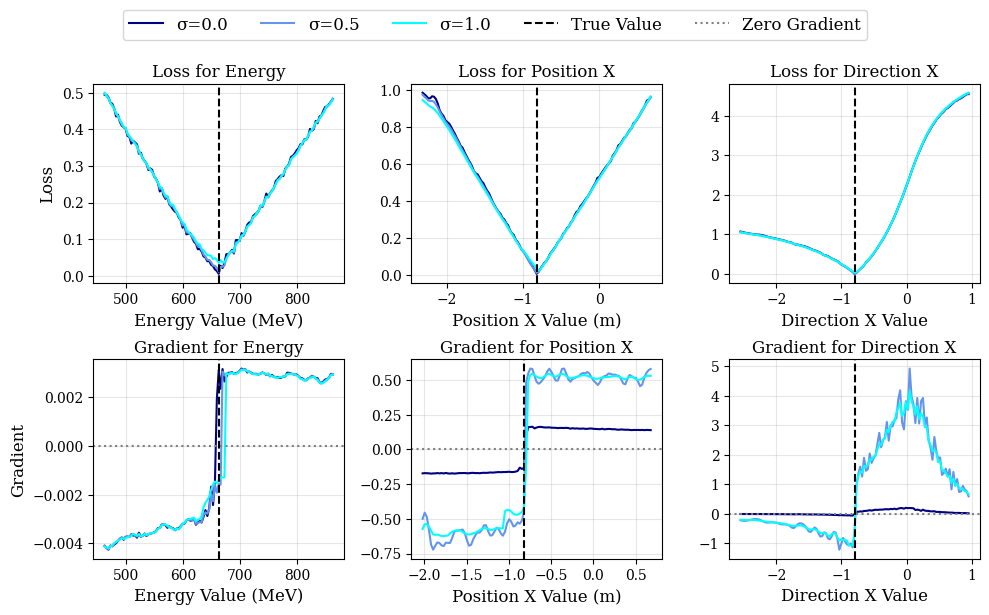

In [13]:
analysis_data = load_analysis_data()
fig, axs = plot_analysis_results(analysis_data)

plt.savefig('1D_loss_and_grads_'+str(key_id)+'_'+str(Nphot)+'.pdf', bbox_inches='tight')
plt.show()

In [14]:
# Define parameter changes as percentages of true values
param_changes = (
    jnp.array(200.0),             # Energy in MeV
    jnp.array([1.5, 0.0, 0.0]),   # position
    jnp.array([1.75, 0.0, 0.0]),  # direction
    jnp.array(1),                 # scatter_length
    jnp.array(0.1),               # reflection_rate
    jnp.array(2),                # absorption_length
)

def generate_param_ranges(true_params, param_changes, num_points=121):
    param_ranges = []
    for i, (true_param, change) in enumerate(zip(true_params[:3] + true_params[4:7], param_changes)):
        if i in [1, 2]:  # position and direction
            start = true_param[0] - change[0]
            end = true_param[0] + change[0]
        else:  # scalar parameters (energy, scatter_length, reflection_rate, absorption_length)
            start = max(true_param - change, 0.0001)  # Ensure non-negative values with small minimum
            end = true_param + change
        param_ranges.append(jnp.linspace(start, end, num_points))
    return param_ranges

def generate_plot_data(param_index, param_values, simulator):
    losses = []
    gradients = []
    loss_and_grad_fn = create_loss_and_grad_fn(simulator, lambda_time=0.000001)
    
    # Map the extended param_index to the actual index in true_params
    actual_param_idx = param_index if param_index < 3 else param_index + 1
    
    for new_value in param_values:
        new_params = list(true_params)
        if actual_param_idx in [1, 2]:  # position and direction
            new_params[actual_param_idx] = new_params[actual_param_idx].at[0].set(new_value)
        else:  # scalar parameters
            new_params[actual_param_idx] = new_value
        new_params = tuple(new_params)
        loss, grad = loss_and_grad_fn(new_params)
        gradient = grad[actual_param_idx]
        if actual_param_idx in [1, 2]:
            gradient = gradient[0]
        losses.append(loss)
        gradients.append(gradient)
    return jnp.array(losses), jnp.array(gradients)

def generate_analysis_data(true_params, param_changes, temperatures, simulators, num_points=121):
    """Generate and save all analysis data."""
    # Generate parameter ranges
    param_ranges = generate_param_ranges(true_params, param_changes, num_points)
    param_names = ['Energy', 'Position X', 'Direction X', 'Scatter Length', 'Reflection Rate', 'Absorption Length']
    
    # Store all data in a dictionary
    analysis_data = {
        'param_ranges': param_ranges,
        'param_names': param_names,
        'true_params': true_params,
        'temperatures': temperatures,
        'results': {}
    }
    
    # Generate data for each parameter and temperature
    for param_idx, param_name in enumerate(tqdm(param_names, desc="Parameters")):
        param_values = param_ranges[param_idx]
        analysis_data['results'][param_name] = {}
        for temp in tqdm(temperatures, desc=f"Temperatures for {param_name}", leave=False):
            losses, gradients = generate_plot_data(param_idx, param_values, simulators[temp])
            analysis_data['results'][param_name][temp] = {
                'losses': losses,
                'gradients': gradients
            }
    
    return analysis_data

def plot_analysis_results(analysis_data):
    """
    Plot the analysis results with a common legend for all subplots.
    Args:
        analysis_data: Dictionary containing all the analysis data
    """
    param_names = analysis_data['param_names']
    temperatures = analysis_data['temperatures']
    true_params = analysis_data['true_params']
    colors = ['navy', 'cornflowerblue', 'cyan']
    
    # Calculate grid dimensions
    n_params = len(param_names)
    n_cols = 3  # Show 3 parameters per row
    n_rows = (n_params + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with 2*n_rows rows (for loss and gradient) and n_cols columns
    fig, axs = plt.subplots(2*n_rows, n_cols, figsize=(15, 5*n_rows))
    
    # If there's only one row, axs needs to be reshaped
    if n_rows == 1:
        axs = axs.reshape(2, n_cols)
    
    # Lists to store legend handles and labels
    all_lines = []
    all_labels = []
    
    # First row for losses, second row for gradients
    for param_idx, param_name in enumerate(param_names):
        row_idx = param_idx // n_cols
        col_idx = param_idx % n_cols
        
        # Get appropriate axes
        ax_loss = axs[2*row_idx, col_idx]
        ax_grad = axs[2*row_idx+1, col_idx]
        
        param_values = analysis_data['param_ranges'][param_idx]
        
        # Map the display param_index to the actual index in true_params
        actual_param_idx = param_idx if param_idx < 3 else param_idx + 1
        
        true_value = true_params[actual_param_idx] if actual_param_idx not in [1, 2] else true_params[actual_param_idx][0]
        
        for temp_idx, temp in enumerate(temperatures):
            results = analysis_data['results'][param_name][temp]
            losses = results['losses']
            gradients = results['gradients']
            label = f'σ={temp}'
            color = colors[temp_idx]
            
            # Plot loss and gradient
            line_loss = ax_loss.plot(param_values, losses, color=color, lw=1.5)[0]
            line_grad = ax_grad.plot(param_values, gradients, color=color, lw=1.5)[0]
            
            # Only store temperature-related legend items from the first parameter
            if param_idx == 0:
                all_lines.append(line_loss)
                all_labels.append(label)
        
        # Add reference lines
        true_line = ax_loss.axvline(x=true_value, color='black', linestyle='--')
        ax_grad.axvline(x=true_value, color='black', linestyle='--')
        zero_line = ax_grad.axhline(y=0, color='gray', linestyle=':')
        
        # Only store reference lines from the first parameter
        if param_idx == 0:
            all_lines.extend([true_line, zero_line])
            all_labels.extend(['True Value', 'Zero Gradient'])
        
        # Configure axes without individual legends
        ax_loss.set_title(f'Loss for {param_name}', pad=5, fontsize=12)
        
        # Set appropriate x-label based on parameter
        if param_name == 'Energy':
            ax_loss.set_xlabel(f'{param_name} Value (MeV)', fontsize=10)
            ax_grad.set_xlabel(f'{param_name} Value (MeV)', fontsize=10)
        elif param_name == 'Position X':
            ax_loss.set_xlabel(f'{param_name} Value (m)', fontsize=10)
            ax_grad.set_xlabel(f'{param_name} Value (m)', fontsize=10)
        elif param_name == 'Scatter Length':
            ax_loss.set_xlabel(f'{param_name} Value (m)', fontsize=10)
            ax_grad.set_xlabel(f'{param_name} Value (m)', fontsize=10)
        elif param_name == 'Absorption Length':
            ax_loss.set_xlabel(f'{param_name} Value (m)', fontsize=10)
            ax_grad.set_xlabel(f'{param_name} Value (m)', fontsize=10)
        else:
            ax_loss.set_xlabel(f'{param_name} Value', fontsize=10)
            ax_grad.set_xlabel(f'{param_name} Value', fontsize=10)
        
        # Only add y-label to leftmost plots
        if col_idx == 0:
            ax_loss.set_ylabel('Loss', fontsize=12)
            ax_grad.set_ylabel('Gradient', fontsize=12)
        
        ax_loss.grid(True, alpha=0.3)
        ax_grad.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for i in range(n_params, n_rows * n_cols):
        row_idx = i // n_cols
        col_idx = i % n_cols
        axs[2*row_idx, col_idx].set_visible(False)
        axs[2*row_idx+1, col_idx].set_visible(False)
    
    # Add common legend below all subplots
    fig.legend(all_lines, all_labels,
              loc='center',
              bbox_to_anchor=(0.5, 0.98),
              ncol=len(all_lines),
              fontsize=12,
              bbox_transform=fig.transFigure)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the legend
    
    return fig, axs

In [15]:
analysis_data = generate_analysis_data(true_params, param_changes, temperatures, event_simulators)
save_analysis_data(analysis_data, filename='extended_analysis_data.pkl')

Parameters: 100%|██████████| 6/6 [03:50<00:00, 38.46s/it]                        


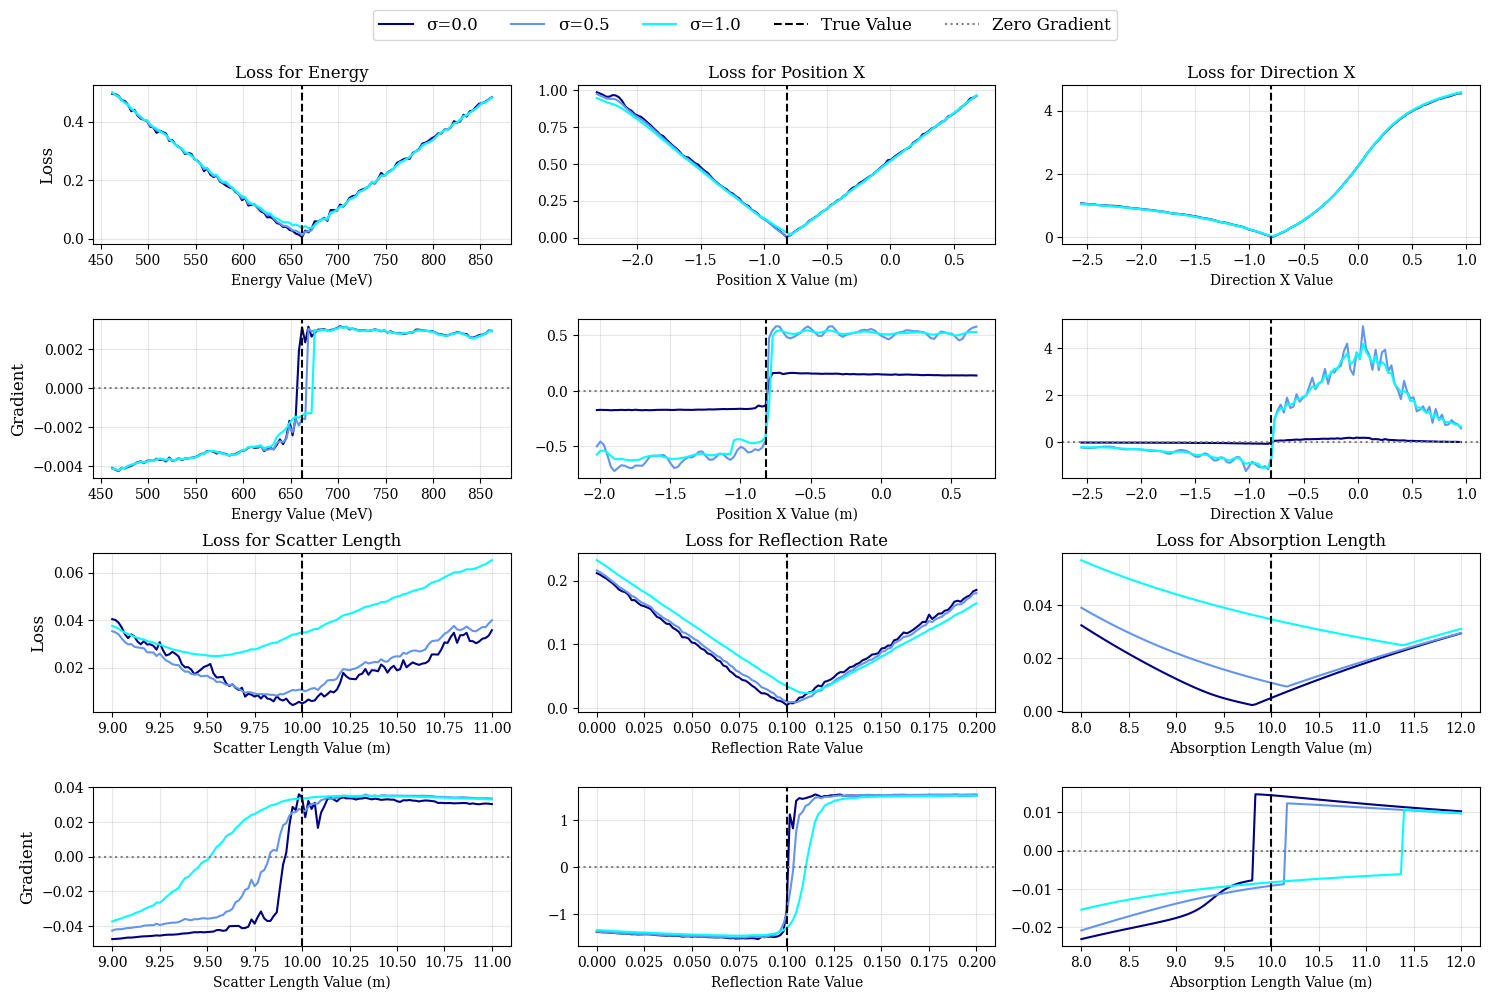

In [16]:
analysis_data = load_analysis_data(filename='extended_analysis_data.pkl')
fig, axs = plot_analysis_results(analysis_data)
plt.savefig('extended_loss_and_grads_'+str(key_id)+'_'+str(Nphot)+'.pdf', bbox_inches='tight')
plt.show()